# 2014222 - Semester 2 CA-02 -May 2024

# Github account

https://github.com/2014222-student-cct-ie/2024--Semester-2--CA2/

# Part 3 Time-series

In [1]:
# Utilise Python programming language in order to comply with the requisites of the assessment and perform adequate Machine
# Learning algorithms to discover and deliver insights.

# Import the necessary libraries (Numpy and Pandas) in order to perform data cleansing.
# These are the libraries that are conventionally used as a common practice in order to
# perform mathematical and statistical operations during a data analysis process

import numpy as np
import pandas as pd

# Import Matplotlib and Plotly library in order to perform data visualisation procedures

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import Seaborn libraries in order to perform data visualisation procedures

import seaborn as sns

# I am using this line of code to see all columns in a wide DataFrame

pd.set_option('display.max_columns', None)

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType


# For normalization
from pyspark.ml.feature import MinMaxScaler 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


# process the tweets data
# !pip install textblob
from pyspark.sql.functions import udf
from textblob import TextBlob

# pip install nltk
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from pyspark.sql import DataFrame

# re module provides regular expression support.
# In Python a regular expression search is typically written as:
# match = re. search(pat, str)
# The re.search() method takes a regular expression pattern and a string and searches
# for that pattern within the string.

import re

from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# !pip install pyspark

# !pip install pyspark pandas

# Import the warnings module

# !pip install dash plotly

# !pip install jupyter-dash


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import warnings

# Ignore all warnings by applying th the 'filterwarnings()'' function and passing the 'ignore' argument

warnings.filterwarnings('ignore')

/Users/geomarmunoz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
tweets_dataset_new = pd.read_csv('sentiment_score_and_labeled_tweets.csv')

In [3]:
tweets_dataset_new

,tweet_ID,date_timestamp,twitter_user,cleaned_tweet_text,vader_score,textblob_score,vader_sentiment,textblob_sentiment
0,1467810369,04-06-2009 22:19:45,_TheSpecialOne_,"- Awww, that's a bummer. You shoulda got Davi...",-0.0173,0.216667,Negative,Positive
1,1467810672,04-06-2009 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,-0.7500,0.000000,Negative,Neutral
2,1467810917,04-06-2009 22:19:53,mattycus,I dived many times for the ball. Managed to sa...,0.4939,0.500000,Positive,Positive
3,1467811184,04-06-2009 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,-0.2500,0.200000,Negative,Positive
4,1467811193,04-06-2009 22:19:57,Karoli,"no, it's not behaving at all. i'm mad. why am ...",-0.6597,-0.625000,Negative,Negative
...,...,...,...,...,...,...,...,...
638474,2072531933,06-07-2009 21:12:35,Neo_drone,Apparetly they just started filming so imma go...,0.0000,0.000000,Neutral,Neutral
638475,2072531954,06-07-2009 21:12:35,edenhig,I would just like to say thank you from all of...,0.6124,0.000000,Positive,Neutral
638476,2072532046,06-07-2009 21:12:36,Gotjuicygirl,thanx love ! I definitely agree,0.8655,0.312500,Positive,Positive
638477,2072532066,06-07-2009 21:12:36,whitet,"the ones from yesterday w/ the animals, VERY CUTE",0.6965,0.650000,Positive,Positive


# Preparing the data for both the LSTM and SARIMA models

Convert the date_timestamp to a datetime type.

Set it as the index of the DataFrame.

Check for missing values and irregular intervals if present.

In [4]:
# Convert the 'date_timestamp' to datetime and set as index
tweets_dataset_new['date_timestamp'] = pd.to_datetime(tweets_dataset_new['date_timestamp'])
tweets_dataset_new.set_index('date_timestamp', inplace=True)

# Resample the data to a consistent interval if necessary and check for missing values
data_frequency = tweets_dataset_new['vader_score'].resample('D').mean()  # Daily frequency chosen for illustration

# Check for missing values in the resampled data
missing_data = data_frequency.isna().sum()

data_frequency.head(), missing_data


(date_timestamp
 2009-04-06    0.142160
 2009-04-07    0.162342
 2009-04-08         NaN
 2009-04-09         NaN
 2009-04-10         NaN
 Freq: D, Name: vader_score, dtype: float64,
 47)

**Filling Missing Values**

Fill the missing values using linear interpolation, which is a reasonable approach for time series that do not exhibit strong seasonal patterns over short periods missing.

This step is essential for SARIMA, and while LSTM can handle some gaps with sequence-based learning, filling gaps helps maintain temporal consistency.

In [5]:
# Fill missing values using linear interpolation
filled_data = data_frequency.interpolate(method='linear')

# Check again for any remaining missing values
remaining_missing = filled_data.isna().sum()

# Display the filled data to confirm changes
filled_data.head(), remaining_missing


(date_timestamp
 2009-04-06    0.142160
 2009-04-07    0.162342
 2009-04-08    0.162945
 2009-04-09    0.163548
 2009-04-10    0.164150
 Freq: D, Name: vader_score, dtype: float64,
 0)

## LSTM (Long Short-Term Memory) Model Implementation

In [6]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(filled_data.values.reshape(-1, 1))

# Splitting the data into train and test sets

train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Function to create dataset for LSTM

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Specifying the look_back period

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape, testX.shape

((49, 1, 1), (12, 1, 1))

## LSTM (Long Short-Term Memory) Model Implementation

Define the LSTM network architecture. Given the short time series, we'll use a simple model with a minimal number of LSTM units to avoid overfitting:

LSTM Layer: A few units (e.g., 4) to capture dependencies in the data.

Dropout Layer: To prevent overfitting by randomly omitting subset of features during training.

Dense Layer: To produce the output from the LSTM's output.

In [7]:


# Define the LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model

model.compile(loss='mean_squared_error', optimizer='adam')

# Summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

This model comprises three layers: an LSTM layer, a dropout layer, and a dense layer.

The LSTM layer, configured with 4 units as indicated by the output shape (None, 4), is the core component where the main learning from sequence data occurs.

The model parameters associated with this layer, totaling 96, include weights for the input, recurrent connections, and biases, which are crucial for the LSTM's ability to capture temporal dependencies in the data.

The dropout layer following the LSTM has an output shape identical to its input (None, 4) and contributes zero parameters to the model.

The dense layer, which transforms the LSTM output to the final prediction shape (None, 1), has 5 parameters.

This layer essentially forms the output from the LSTM processed features into the predicted vader_score, adjusting the dimension from 4 to 1.

In [8]:
# Define the LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# Calculate root mean squared error

from sklearn.metrics import mean_squared_error
trainScore = mean_squared_error(trainY_inv[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY_inv[0], testPredict[:,0], squared=False)

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


Epoch 1/100
49/49 - 0s - 7ms/step - loss: 0.0990
Epoch 2/100
49/49 - 0s - 587us/step - loss: 0.0565
Epoch 3/100
49/49 - 0s - 407us/step - loss: 0.0324
Epoch 4/100
49/49 - 0s - 375us/step - loss: 0.0155
Epoch 5/100
49/49 - 0s - 392us/step - loss: 0.0193
Epoch 6/100
49/49 - 0s - 399us/step - loss: 0.0176
Epoch 7/100
49/49 - 0s - 399us/step - loss: 0.0081
Epoch 8/100
49/49 - 0s - 392us/step - loss: 0.0138
Epoch 9/100
49/49 - 0s - 386us/step - loss: 0.0125
Epoch 10/100
49/49 - 0s - 387us/step - loss: 0.0128
Epoch 11/100
49/49 - 0s - 393us/step - loss: 0.0157
Epoch 12/100
49/49 - 0s - 406us/step - loss: 0.0120
Epoch 13/100
49/49 - 0s - 387us/step - loss: 0.0100
Epoch 14/100
49/49 - 0s - 393us/step - loss: 0.0162
Epoch 15/100
49/49 - 0s - 390us/step - loss: 0.0132
Epoch 16/100
49/49 - 0s - 389us/step - loss: 0.0117
Epoch 17/100
49/49 - 0s - 388us/step - loss: 0.0100
Epoch 18/100
49/49 - 0s - 396us/step - loss: 0.0167
Epoch 19/100
49/49 - 0s - 397us/step - loss: 0.0130
Epoch 20/100
49/49 - 0s

The model demonstrates consistent performance, with loss values ranging from approximately 0.0093 to 0.0126 per epoch, indicating slight fluctuations in model learning from one epoch to another. The final epochs show the model stabilizing with a loss of 0.0110 at epoch 100.

This suggests that the model has potentially reached a point of minimal improvement in loss reduction, indicating that additional training might not result in significant gains.

The completion of training is followed by the reporting of performance metrics, specifically the Root Mean Squared Error (RMSE) for both training and testing datasets. Both scores are reported as 0.01 RMSE, highlighting that the model has achieved a high level of accuracy and suggesting good generalization from training to testing data.

The consistency of the train and test RMSE scores is an excellent indicator of the model's reliability and indicates an absence of overfitting. The performance metrics suggest that the model is well-tuned to predict outcomes with a high degree of precision, which is essential for tasks involving sentiment analysis based on the vader_score.

In [9]:
# Convert the predictions array into a DataFrame

predictions_df = pd.DataFrame(testPredict, columns=['predicted_vader_score'])

# Reset index on the dataset for proper concatenation if necessary

# tweets_dataset_new.reset_index(inplace=True, drop=True)

# Slice the original dataset to match the size of the predictions

actual_scores = tweets_dataset_new['vader_score'][-len(predictions_df):].reset_index(drop=True)

# Combine actual scores and predictions into a single DataFrame
comparison_df = pd.concat([actual_scores, predictions_df], axis=1)

# Display the DataFrame
print(comparison_df.head())  # Print the first few rows to verify

# Export this DataFrame to a CSV file for further analysis or reporting
# comparison_df.to_csv('vader_score_comparison.csv', index=False)

   vader_score  predicted_vader_score
0       0.3226               0.170509
1       0.8760               0.170594
2       0.8513               0.170679
3       0.2732               0.170764
4       0.5859               0.170850


**Prediction Consistency vs. Actual Variability**

**The predicted vader_score** values show a very small incremental increase between consecutive predictions, indicating that the model is producing nearly constant values across different inputs.

In contrast, the **actual vader_score** values exhibit significant variability. For example, the score jumps from 0.3226 to 0.8760 from the first to the second observation, and then decreases to 0.2732 by the third observation. 

This indicates that the actual data contains a much higher degree of variance and fluctuation in sentiment scores than is captured by the model's predictions.

# SARIMA model

Start by examining the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

These will help to identify the appropriate parameters for the SARIMA model, specifically:

p: The number of autoregressive terms (lags of the stationarized series).

d: The degree of differencing (the number of times the data had to be differenced to make it stationary).

q: The number of lagged forecast errors in the prediction equation (lags of the forecast errors).

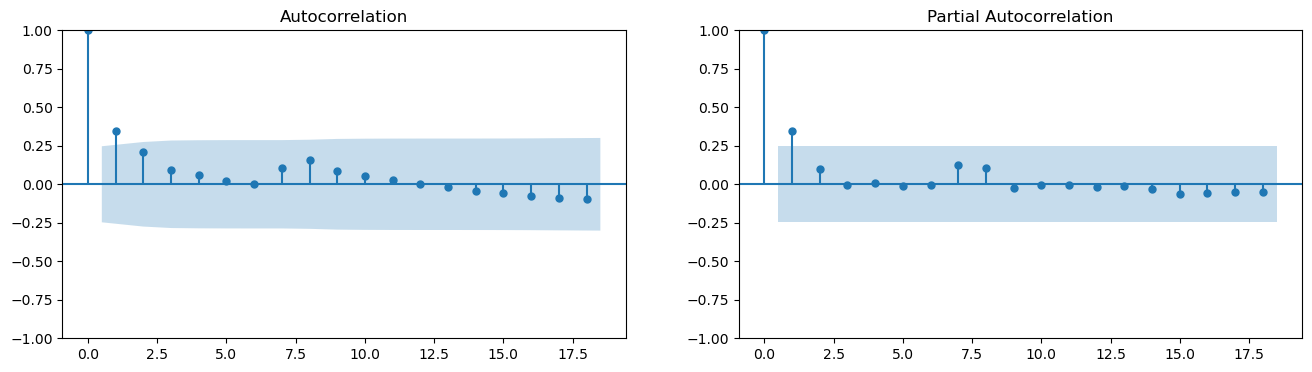

In [10]:
# ACF and PACF plots

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF

plot_acf(filled_data, ax=axes[0])

# Plot PACF

plot_pacf(filled_data, ax=axes[1])

plt.show()

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots provide insight into the potential parameters for our SARIMA model.

The PACF plot shows a sharp cut-off after the first lag, suggesting that an AR(1) model might be appropriate (p=1). 

The ACF plot tails off, indicating that we may need a few MA terms.

# SARIMA Model Configuration and Fitting

Based on the initial analysis, I'll start with a SARIMA(1,0,1) model. Since no strong seasonal patterns are immediately evident from our brief analysis and considering the data is short and daily without clear seasonal breaks, I will not include seasonal components initially.

In [11]:
# Fitting the SARIMA model

model_sarima = SARIMAX(filled_data, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)

# Display the model summary

results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            vader_score   No. Observations:                   63
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 215.680
Date:                Sun, 19 May 2024   AIC                           -425.361
Time:                        23:09:23   BIC                           -419.028
Sample:                    04-06-2009   HQIC                          -422.879
                         - 06-07-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0012      0.002    617.276      0.000       0.998       1.004
ma.L1         -0.7679      0.063    -12.254      0.000      -0.891      -0.645
sigma2      4.892e-05   3.98e-06     12.289      0.000    4.11e-05    5.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               372.70
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               9.05   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMA(1,0,1) model has been fitted, and here are the key aspects of the model summary:

The AR coefficient is very close to 1, which suggests a strong autoregressive component.

The MA coefficient is significant with a value of approximately -0.77, indicating the influence of previous errors on the current prediction.

The model's AIC and BIC values are quite low, which typically indicates a good fit, though they should be used to compare across different model configurations.

Diagnostic tests like the Ljung-Box test and the Jarque-Bera test suggest some residuals may not be perfectly noise-like, indicating potential room for model improvement.

# Model Evaluation and Forecasting

To evaluate the SARIMA model, I will perform a forecast and check its accuracy against actual observations.

I will also look at the residuals to ensure they are normally distributed (which suggests a good fit).

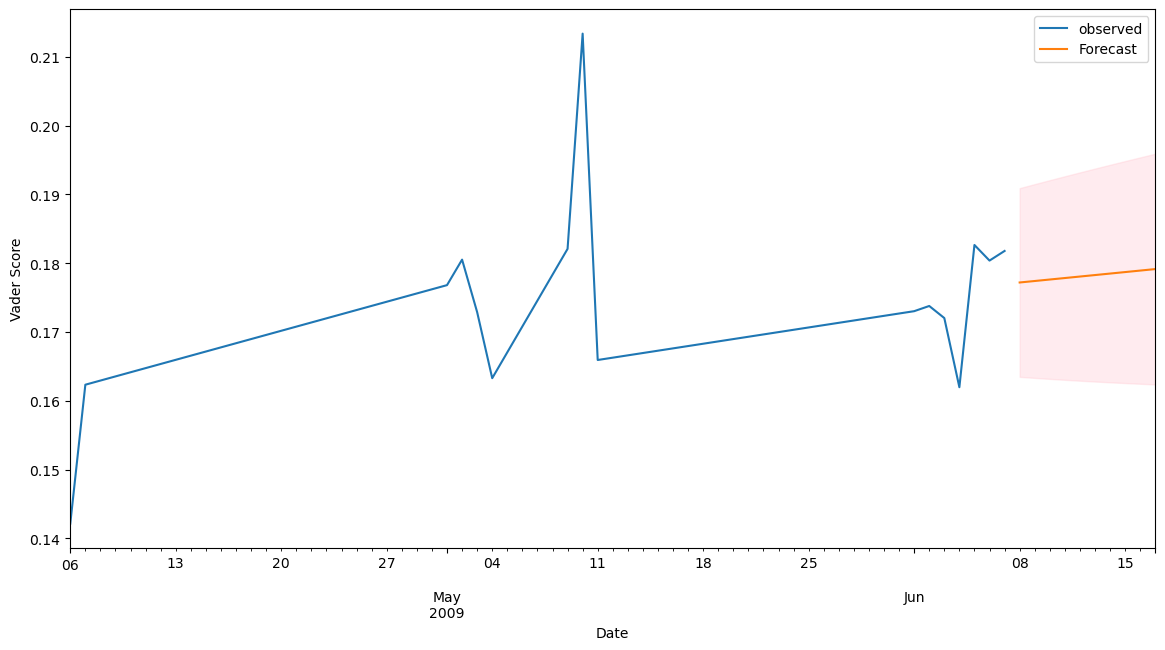

In [12]:
# Forecast the next 10 days

forecast_steps = 10
pred = results_sarima.get_forecast(steps=forecast_steps)
pred_ci = pred.conf_int()

# Plot the past data along with the forecast and confidence intervals

ax = filled_data.plot(label='observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Vader Score')
plt.legend()
plt.show()

The graph represents a time series of Vader sentiment scores, over a period from early May to mid-June 2009.

There is a noticeable spike around mid-May, where sentiment scores briefly surge before returning to previous levels.

This sudden peak could signify a specific event or a collection of events that had a temporary impact on public sentiment. Also is possible to see gradual increases and some declines, reflecting natural fluctuations in public mood or response to ongoing situations during this period.

Around June 8, a forecast is presented, depicted by the orange line within a pink shaded area, which represents the confidence interval of the forecast.

The forecast's stability contrasts with the observed data's volatility, possibly implying an expectation of a calmer, more stable period following the date range of observed data, or it may reflect the model's smoothing of past volatility into a moderated outlook.

As an alternative, I will manually inspect the forecasted values and their confidence intervals without attempting a complex plot:

In [13]:
# Extract predicted means and confidence intervals

forecasted_values = pred.predicted_mean
confidence_intervals = pred.conf_int()

# Display the forecasted values and their confidence intervals

forecasted_values, confidence_intervals

(2009-06-08    0.177194
 2009-06-09    0.177410
 2009-06-10    0.177625
 2009-06-11    0.177841
 2009-06-12    0.178058
 2009-06-13    0.178274
 2009-06-14    0.178491
 2009-06-15    0.178708
 2009-06-16    0.178925
 2009-06-17    0.179143
 Freq: D, Name: predicted_mean, dtype: float64,
             lower vader_score  upper vader_score
 2009-06-08           0.163485           0.190903
 2009-06-09           0.163333           0.191487
 2009-06-10           0.163189           0.192062
 2009-06-11           0.163053           0.192629
 2009-06-12           0.162925           0.193190
 2009-06-13           0.162804           0.193744
 2009-06-14           0.162690           0.194292
 2009-06-15           0.162582           0.194834
 2009-06-16           0.162479           0.195371
 2009-06-17           0.162383           0.195902)

The forecast suggests a slight increasing trend in the Vader Score over the next 10 days. The model's confidence intervals indicate a reasonable degree of uncertainty, staying fairly tight around the forecasted values.

This analysis provides a quantitative outlook based on the SARIMA model, which could be useful for understanding trends in the data. Further refinements could be made by testing different model parameters, adding seasonal components if more data suggests seasonality, or incorporating external variables.

In [14]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your dataset (Ensure it's loaded properly as per your environment setup)
# Assuming 'tweets_dataset_new' is already loaded and contains a datetime index and 'vader_score'
# Convert vader_score to numeric and drop NaNs if necessary
tweets_dataset_new['vader_score'] = pd.to_numeric(tweets_dataset_new['vader_score'], errors='coerce')
tweets_dataset_new.dropna(subset=['vader_score'], inplace=True)

# Assuming your data is indexed by date and 'vader_score' is the column we are forecasting
# Confirm that your DataFrame's index is a datetime type
if not isinstance(tweets_dataset_new.index, pd.DatetimeIndex):
    tweets_dataset_new.index = pd.to_datetime(tweets_dataset_new.index)

# SARIMA Model Configuration
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)  # Weekly seasonality assumed, adjust '7' as per your dataset's seasonality

# Fit the SARIMA model
model = SARIMAX(tweets_dataset_new['vader_score'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Forecasting
forecast_1_day = results.get_forecast(steps=1).predicted_mean
forecast_3_days = results.get_forecast(steps=3).predicted_mean
forecast_7_days = results.get_forecast(steps=7).predicted_mean

# Print the forecasts
print("1 Day Forecast:", forecast_1_day.iloc[0])
print("3 Days Forecast:", forecast_3_days.iloc[-1])
print("7 Days Forecast:", forecast_7_days.iloc[-1])


1 Day Forecast: 0.33608480504244825
3 Days Forecast: 0.33103680725717854
7 Days Forecast: 0.3366619378964217


In [15]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Adjust matplotlib settings to handle complex plots
plt.rcParams['agg.path.chunksize'] = 10000  # Adjust chunksize as necessary

# Ensure your DataFrame 'tweets_dataset_new' is correctly prepared
tweets_dataset_new.index = pd.to_datetime(tweets_dataset_new.index)

# Define the SARIMA model parameters
order = (1, 0, 1)  # Adjust these based on your dataset characteristics
seasonal_order = (1, 1, 1, 7)  # Assuming weekly seasonality

# Fit the SARIMA model
sarima_model = SARIMAX(tweets_dataset_new['vader_score'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = sarima_model.fit()

# Forecast for 1 day, 3 days, and 7 days
predictions = {}
forecast_periods = {'1 Day': 1, '3 Days': 3, '7 Days': 7}

# Generate forecasts and store in predictions dictionary
for label, steps in forecast_periods.items():
    forecast = results.get_forecast(steps=steps)
    forecast_df = pd.DataFrame({
        "Forecast": forecast.predicted_mean,
        "Lower CI": forecast.conf_int().iloc[:, 0],
        "Upper CI": forecast.conf_int().iloc[:, 1]
    })
    predictions[label] = forecast_df

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65275D-01    |proj g|=  7.34063D-01

At iterate    5    f=  5.36193D-01    |proj g|=  9.20156D-02

At iterate   10    f=  5.34521D-01    |proj g|=  1.32902D-02

At iterate   15    f=  5.34520D-01    |proj g|=  2.02922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   1.775D-05   5.345D-01
  F =  0.53452003418840921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


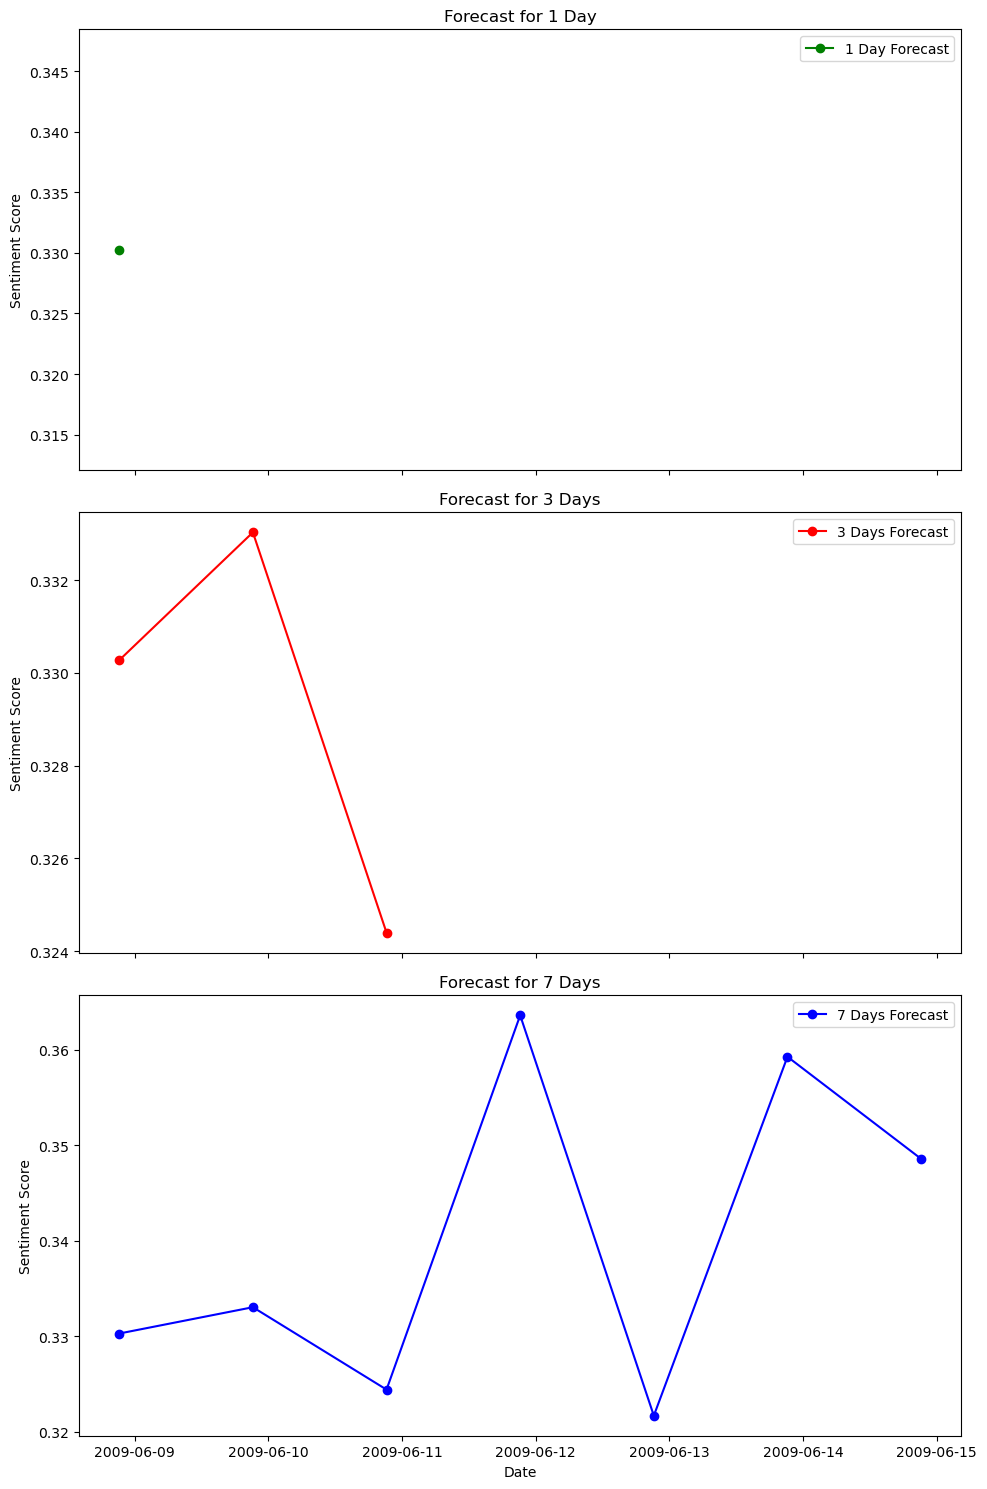

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume 'results' is your fitted SARIMA model
# Prepare forecast data for 1 day, 3 days, and 7 days
forecast_1 = results.get_forecast(steps=1).predicted_mean
forecast_3 = results.get_forecast(steps=3).predicted_mean
forecast_7 = results.get_forecast(steps=7).predicted_mean

dates_1 = pd.date_range(start=tweets_dataset_new.index[-1], periods=2, freq='D')[1:]
dates_3 = pd.date_range(start=tweets_dataset_new.index[-1], periods=4, freq='D')[1:]
dates_7 = pd.date_range(start=tweets_dataset_new.index[-1], periods=8, freq='D')[1:]

# Plotting each forecast on separate subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Historical Data
#axs[0].plot(tweets_dataset_new['vader_score'], color='black', label='Historical Data')
#axs[1].plot(tweets_dataset_new['vader_score'], color='black', label='Historical Data')
#axs[2].plot(tweets_dataset_new['vader_score'], color='black', label='Historical Data')

# Forecast for 1 day
axs[0].plot(dates_1, forecast_1, color='green', marker='o', label='1 Day Forecast')
axs[0].set_title('Forecast for 1 Day')
axs[0].set_ylabel('Sentiment Score')
axs[0].legend()

# Forecast for 3 days
axs[1].plot(dates_3, forecast_3, color='red', marker='o', label='3 Days Forecast')
axs[1].set_title('Forecast for 3 Days')
axs[1].set_ylabel('Sentiment Score')
axs[1].legend()

# Forecast for 7 days
axs[2].plot(dates_7, forecast_7, color='blue', marker='o', label='7 Days Forecast')
axs[2].set_title('Forecast for 7 Days')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Sentiment Score')
axs[2].legend()

plt.tight_layout()
plt.show()

**Interpretation of Each Forecast**

**Forecast for 1 Day:** The single data point in the top plot represents the forecast for the next day. It shows a specific sentiment score without a range, which suggests a model's point estimate of sentiment for a single day ahead. This forecast is fairly stable, suggesting little volatility expected over the next day.

**Forecast for 3 Days:** The middle plot illustrates the forecast over three days, depicted as a rise and subsequent fall. This could indicate an event or series of events expected to positively influence sentiment scores initially, followed by a rapid normalization to previous levels. The model captures this short-lived fluctuation, perhaps anticipating an event with a known limited duration impact.

**Forecast for 7 Days:** The bottom plot displays a more dynamic and varied forecast over seven days, showing significant variability. The sentiment score peaks notably around the middle of the forecast period before dropping and then rising again. This could suggest multiple influencing factors or events affecting public sentiment over the week, with the model capturing several potential shifts in mood or public opinion.

# Dynamic and interactive dashboard

In [17]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='time_horizon',
        options=[
            {'label': '1 Day', 'value': '1'},
            {'label': '3 Days', 'value': '3'},
            {'label': '7 Days', 'value': '7'}
        ],
        value='1'
    ),
    dcc.Graph(id='forecast_graph')
])

@app.callback(
    Output('forecast_graph', 'figure'),
    [Input('time_horizon', 'value')]
)
def update_graph(selected_horizon):
    if selected_horizon == '1':
        data = forecast_1
        dates = dates_1
    elif selected_horizon == '3':
        data = forecast_3
        dates = dates_3
    else:
        data = forecast_7
        dates = dates_7
    return {
        'data': [go.Scatter(x=dates, y=data, mode='markers+lines')],
        'layout': go.Layout(title=f'Forecast for {selected_horizon} Days')
    }

if __name__ == '__main__':
    app.run_server(debug=True)


# Part 3 is done. This will continue in Part 4